In [7]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [8]:
def errors(n, r=1):
    
    mesh = UnitIntervalMesh(n)

    # start by solving for u using non-hybrid CG
    V = VectorFunctionSpace(mesh, 'CG', r)
    bcs = [DirichletBC(V, Constant((0,)), DomainBoundary())]
    
    u = TrialFunction(V)
    v = TestFunction(V)
    a = inner(div(u), div(v))*dx
    f = Expression(("pow(pi,2)*sin(pi*x[0])",), degree=r+1)
    L = inner(f, v)*dx
    
    u = Function(V)
    solve(a == L, u, bcs)
    
    div_u = project(div(u), FunctionSpace(mesh, "DG", r-1))
        
    # post-process to estimate q = div(u) in H^1
    V_dg_element = VectorElement('DG', mesh.ufl_cell(), r)
    Q_element = FiniteElement('CG', mesh.ufl_cell(), r+1)
    W = FunctionSpace(mesh, V_dg_element*Q_element)
    
    lam, q = TrialFunctions(W)
    v, p = TestFunctions(W)
    a = (inner(q, p) + inner(grad(q), grad(p)) - div(lam*p + v*q) + 1e-10*inner(lam, v))*dx
    L = (inner(f, v - grad(p)) + inner(div_u, p - div(v)))*dx
    
    w = Function(W)
    solve(a == L, w)
    q = w.sub(1)
    
    # exact solutions
    u_exact = Expression(("sin(pi*x[0])",), degree=r+3)
    q_exact = Expression("pi*cos(pi*x[0])", degree=r+4)

    u_error = errornorm(u_exact, u)
    div_u_error = errornorm(q_exact, div_u)
    q_error = errornorm(q_exact, q)

    return u_error, div_u_error, q_error

In [9]:
ns = [2**k for k in range(1,5)]
es = [errors(n, r=1) for n in ns]

Text(0, 0.5, 'error')

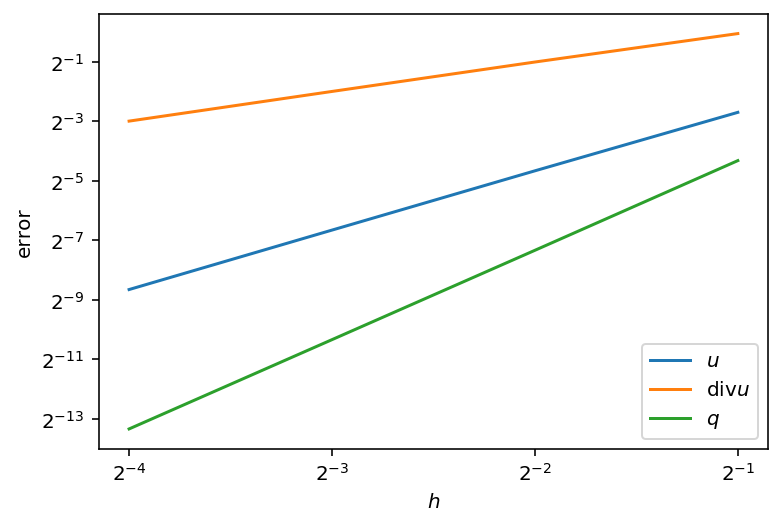

In [10]:
plt.loglog(1/np.array(ns), es, basex=2, basey=2)
plt.legend(['$u$',r'$\operatorname{div} u$', '$q$'])
plt.xlabel('$h$')
plt.ylabel('error')

In [11]:
es

[(0.1543285121855709, 0.9668565531959656, 0.050126090544410244),
 (0.0395305125275644, 0.4985052887928073, 0.006205497297124989),
 (0.009936760416785071, 0.25118164536258447, 0.0007741124948984143),
 (0.002487498408081571, 0.12583315441103338, 9.671706958236847e-05)]

In [12]:
rates = -np.diff(np.log2(es), axis=0)
rates

array([[1.96496606, 0.95569305, 3.01394298],
       [1.99211917, 0.98887776, 3.00293169],
       [1.99807998, 0.99721895, 3.0007008 ]])